<div style="line-height:0.5">
<h1 style="color:#FF7C00  "> Radial Basis Network in TensorFlow 2 </h1>
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> "& nbsp;" in markdown + keras backend utilities (expand_dims) + model history
    
</span>
</div> 

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Layer
from keras import backend as K
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import binary_crossentropy

from tensorflow.keras.datasets import mnist

In [15]:
class RBFLayer(Layer):
    """ Implementation of a RBF (Radial Basis Function) Layer with a custom Keras layer.\\
    It computes the output of the RBF layer based on the input and trainable parameters.

    Parameters:
        - Number of units (neurons) in the RBF layer [int]
        - Spread of the radial basis functions [float]

    Attributes:
        - units => Number of neurons
        - gamma => Spread
        - mu => Weight variable representing the centers of the radial basis functions [tf.Tensor]

    Methods:
        - build(input_shape): Builds the layer by creating the mu weight variable.
        - call(inputs): Computes the output of the layer based on the input and mu.
        - compute_output_shape(input_shape): Computes the output shape of the layer.
    """
    def __init__(self, units, gamma, **kwargs):
        """ Initialize the RBFLayer. """
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        """ Build the RBFLayer by creating the mu weight variable, defining and\\ 
        initializing a weight tensor "mu" in the RBFLayer.\\
        It allows the weights to be updated during training to learn the centers of the radial basis functions.

        Parameters:
            - Shape of the input tensor [tuple]

        Details:
            - Add a new weight variable to the layer (built-in method provided by Keras).\\
                The weight will be part of the layer's trainable parameters.
                - self.mu: weight value for the centers of the radial basis functions.\\ 
                    These centers are learned during the training process.
                - Set the shape of the weight tensor => (Num of input features ; Num of RBF units in the layer)
                - Initialize weights using a uniform distribution.
                - "trainable=True" it is necessary to indicate that the mu weights should be trainable\\
                    during the model's training process.
        """
        self.mu = self.add_weight(name='mu',
                                shape=(int(input_shape[1]), self.units),
                                initializer='uniform',
                                trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        """ Calculate the output of the RBFLayer based on the input and mu.\\
            Compute the radial basis function (RBF) values for each input point based on their distances to the learned centers.

        Parameters:
            - Input data [tf.Tensor]

        Details:
            - Expand the dimensions of the input tensor to have an additional axis,\\
                to match the shape of 'self.mu' for proper element-wise subtraction
            - Calculate the difference between each input point and the centers of the radial basis functions with "diff"\\
                Element-wise difference results in a tensor where each row corresponds to the\\ 
                difference between an input point and each center
            - K.pow(diff, 2) => Element-wise square of the differences calculated in the previous step
            - K.sum(...) => Sum of the squared differences along axis=1
            - 'l2' => Tensor of th squared Euclidean distances between each input point and each center

        Returns:
            - Computed RBF values, representing the layer's output for the given input data [tf.Tensor]
        """
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res


    def compute_output_shape(self, input_shape):
        """ Return the computed output shape of the layer. """
        return (input_shape[0], self.units)

In [16]:
""" Split MNIST dataset """
(X_train, y_train), (X_test, y_test) = mnist.load_data()
y_train = (y_train <= 25).astype(int)
y_test = (y_test <= 25).astype(int)

<div style="line-height:0.4">
<h3 style="color:#FF7C00  "> Sequential </h3>
Create the sequential model, a Keras linear stack of layers where layers are added one by one.
</div>

&nbsp;&nbsp; 1) Flatten layer to reshape the input data, which in this case is a 2D array of shape (28, 28), into a 1D array of shape (784,)     
&nbsp;&nbsp; 2) RBF layer with radial basis functions, used for non-linear mappings    
&nbsp;&nbsp; 3) Fully connected Dense layer, where each neuron is connected to every one in the previous layer     
&nbsp;&nbsp;&nbsp;&nbsp; [=> 1 neuron + sigmoid activation function]      

<div style="line-height:0.4">
<h3 style="color:#FF7C00  "> Compile </h3>
Prepare the model to train configuring:
<div style="line-height:1">
</div>
<div style="line-height:1.5">

- The loss => binary_crossentropy     
- The optimization algorithm => 'rmsprop' (Root Mean Squared Propagation)      
- Stochastic mini-batch learning method that:   
&nbsp;&nbsp;&nbsp;&nbsp; - Divide the gradient by the root of this average    
&nbsp;&nbsp;&nbsp;&nbsp; - Use plain momentum   
&nbsp;&nbsp;&nbsp;&nbsp; - Maintain a moving (discounted) average of the square of gradients  
</div>

<div style="line-height:0.5">
<h2 style="color:#FF7C00  ">  <u> Example 1 </u> </h2> Without RBFLayer layer
</div>

In [17]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(1, activation='sigmoid', name='foo'))

model.compile(optimizer='rmsprop', loss=binary_crossentropy)

In [18]:
history = model.fit(X_train, y_train, batch_size=256, epochs=3)

Epoch 1/3


235/235 [==============================] - 1s 4ms/step - loss: 0.1088
Epoch 2/3
235/235 [==============================] - 1s 4ms/step - loss: 6.9353e-06
Epoch 3/3
235/235 [==============================] - 1s 5ms/step - loss: 4.9060e-13


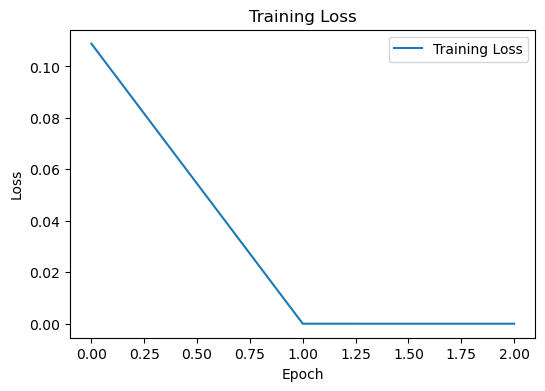

In [19]:
""" Visualize the training loss over epochs. """
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Predict test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

313/313 [==============================] - 1s 2ms/step - loss: 7.2062e-16
Test Loss: 7.206152386402865e-16


<div style="line-height:0.5">
<h2 style="color:#FF7C00  ">  <u> Example 2 </u> </h2> Add one RBFLayer layer
</div>

In [21]:
model2 = Sequential()
model2.add(Flatten(input_shape=(28, 28)))
model2.add(RBFLayer(20, 0.5))
model2.add(Dense(1, activation='sigmoid', name='foo'))

model2.compile(optimizer='rmsprop', loss=binary_crossentropy)

history2 = model2.fit(X_train, y_train, batch_size=256, epochs=3)

Epoch 1/3
235/235 [==============================] - 12s 46ms/step - loss: 0.6331
Epoch 2/3
235/235 [==============================] - 11s 46ms/step - loss: 0.5302
Epoch 3/3
235/235 [==============================] - 10s 42ms/step - loss: 0.4405


In [22]:
# Predict test data
test_loss2 = model2.evaluate(X_test, y_test)
print("Test Loss:", test_loss2)

313/313 [==============================] - 1s 3ms/step - loss: 0.3997
Test Loss: 0.39972537755966187


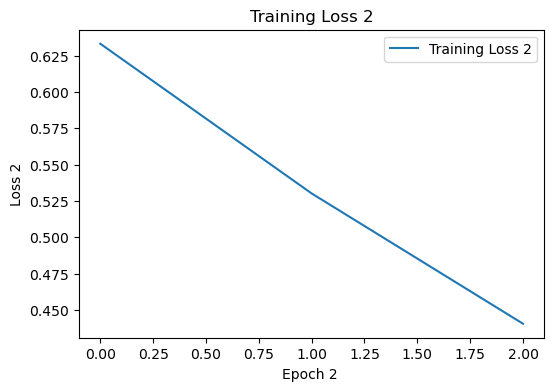

In [23]:
""" Visualize the training loss over epochs. """
plt.figure(figsize=(6, 4))
plt.plot(history2.history['loss'], label='Training Loss 2')
plt.title('Training Loss 2')
plt.xlabel('Epoch 2 ')
plt.ylabel('Loss 2')
plt.legend()
plt.show()

<div style="line-height:0.5">
<h2 style="color:#FF7C00  ">  <u> Example 3 </u> </h2> With two RBFLayer layers
</div>

In [24]:
model3 = Sequential()
model3.add(Flatten(input_shape=(28, 28)))
model3.add(RBFLayer(20, 0.5))
model3.add(RBFLayer(20, 0.5))
model3.add(Dense(1, activation='sigmoid', name='foo'))

model3.compile(optimizer='rmsprop', loss=binary_crossentropy)

history3 = model3.fit(X_train, y_train, batch_size=256, epochs=3)

Epoch 1/3
235/235 [==============================] - 10s 41ms/step - loss: 0.3113
Epoch 2/3
235/235 [==============================] - 9s 39ms/step - loss: 0.0060
Epoch 3/3
235/235 [==============================] - 9s 39ms/step - loss: 2.3005e-04


In [25]:
# Predict test data
test_loss3 = model3.evaluate(X_test, y_test)
print("Test Loss:", test_loss3)

313/313 [==============================] - 1s 3ms/step - loss: 8.8187e-05
Test Loss: 8.818745845928788e-05


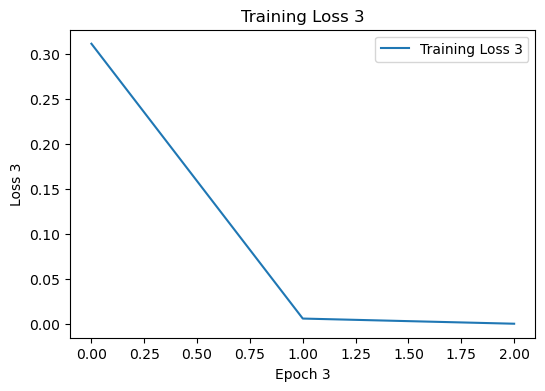

In [26]:
""" Visualize the training loss over epochs. """
plt.figure(figsize=(6, 4))
plt.plot(history3.history['loss'], label='Training Loss 3')
plt.title('Training Loss 3')
plt.xlabel('Epoch 3')
plt.ylabel('Loss 3')
plt.legend()
plt.show()